In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import rotate

Setting environment for Gordon


In [ ]:
cell_masks = []

stack = 'MD589'

for sec in range(93, 143, 10):
# sec = 113
    blob_coords = pickle.load(open('/home/yuncong/csd395/CSHL_cells/%(stack)s_%(sec)04d_blobCoords.pkl' % {'stack': stack, 'sec': sec}, 'r'))
    blob_orientations = bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_cells/%(stack)s_%(sec)04d_blobOrientations.bp' % {'stack': stack, 'sec': sec})

    blob_centers = [coords.mean(axis=0) for coords in blob_coords]

    for blob_index_inSec, coords in enumerate(blob_coords):
        ymin, xmin = coords.min(axis=0)
        ymax, xmax = coords.max(axis=0)
        cell_mask = np.zeros((ymax+1-ymin, xmax+1-xmin), np.bool)
        cell_mask[coords[:,0]-ymin, coords[:,1]-xmin] = 1

        patch_rotationNormalized = rotate(cell_mask, angle=-np.rad2deg(blob_orientations[blob_index_inSec]), 
                      center=(blob_centers[blob_index_inSec][1] - xmin, blob_centers[blob_index_inSec][0] - ymin),
                      cval=0.) > .5

        cell_masks.append(patch_rotationNormalized)

In [ ]:
cell_masks_normalized = np.asarray(pad_patches_to_same_size(cell_masks, pad_value=0, keep_center=True))

In [ ]:
bp.pack_ndarray_file(cell_masks_normalized, '/home/yuncong/csd395/CSHL_cells/fractal_dim/cell_masks_normalized.bp')

In [3]:
cell_masks_normalized = bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_cells/fractal_dim/cell_masks_normalized.bp')

In [4]:
n_cells = len(cell_masks_normalized)
print n_cells, 'cells'

cell_masks_normalized_flattened = np.reshape(cell_masks_normalized, (len(cell_masks_normalized), -1))
cell_masks_normalized_flattened.shape

cell_masks_normalized_size = cell_masks_normalized_flattened.sum(axis=1)

197953 cells


In [ ]:
# visualize some random cells
indices = np.random.randint(0, n_cells, 10)
display_images_in_grids([cell_masks_normalized[i] for i in indices], 10, maintain_shape=False)

In [6]:
memberCount = np.bincount(indices_of_closest_seed, minlength=len(seeds))
seedIndices_sorted_by_memberCount = np.argsort(memberCount)[::-1]
memberCount_sorted = memberCount[seedIndices_sorted_by_memberCount]
seeds_ranked_by_memberCount = seeds[seedIndices_sorted_by_memberCount]

In [7]:
memberCount_sorted

array([252, 245, 196, ...,   1,   1,   1])

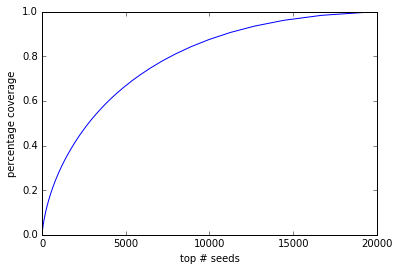

In [8]:
plt.plot(np.cumsum(memberCount_sorted) / float(n_cells));
plt.xlabel('top # seeds');
plt.ylabel('percentage coverage');

In [9]:
from multiprocess import Pool

In [10]:
from scipy.sparse import dok_matrix, coo_matrix

In [11]:
from scipy.spatial.distance import squareform

def compute_jaccard_list_with_all(seed_indices):

    pool = Pool(14)
    affinities_to_seeds = pool.map(compute_jaccard_with_i, seed_indices)
    pool.close()
    pool.join()
    return np.asarray(affinities_to_seeds)

def compute_jaccard_with_i_list(i, indices):
    intersections = cell_masks_normalized_flattened[indices[:,None], cell_masks_normalized_flattened[i]].sum(axis=1)
    unions = cell_masks_normalized_size[i] + cell_masks_normalized_size[indices] - intersections
    scores = intersections.astype(np.float)/unions
    return scores
    
def compute_jaccard_pairwise(indices, square_form=True, parallel=True):
    n = len(indices)

    if parallel:
        pool = Pool(16)
        pairwise_scores = pool.map(lambda x: compute_jaccard_with_i_list(x[0],x[1]), 
                                   [(indices[i], indices[i+1:]) for i in range(n)])
        pool.close()
        pool.join()
    else:
        pairwise_scores = [compute_jaccard_with_i_list(indices[i], indices[i+1:]) for i in range(n)]
        
    if square_form:
        return squareform(np.concatenate(pairwise_scores))
    else:
        return pairwise_scores
    
# def compute_jaccard_with_i_slave(args):
#     i, j1, j2 = args
# #     intersections_with_i = (cell_masks_normalized_flattened[i] & cell_masks_normalized_flattened[j1:j2+1]).sum(axis=1)
#     intersections_with_i = cell_masks_normalized_flattened[j1:j2+1, cell_masks_normalized_flattened[i]].sum(axis=1)
#     unions_with_i = cell_masks_normalized_size[i] + cell_masks_normalized_size[j1:j2+1] - intersections_with_i
    
# #     S = cell_masks_normalized_flattened[j1:j2+1]
# #     intersections_with_i = S[:, cell_masks_normalized_flattened[i]].sum(axis=1)
# #     unions_with_i = cell_masks_normalized_size[i] + S - intersections_with_i
    
# #     intersections_with_i = cell_masks_normalized_flattened[j1:j2+1, cell_masks_normalized_flattened[i]].sum(axis=1)
# #     unions_with_i = cell_masks_normalized_size[i] + cell_masks_normalized_size[j1:j2+1] - intersections_with_i
#     return intersections_with_i.astype(np.float)/unions_with_i

# def compute_jaccard_with_i_parallel(i):
    
#     # overhead is too much, not saving time
    
#     from multiprocess import Pool
    
#     n_jobs = 8
#     pool = Pool(n_jobs)

#     slave_start_indices = np.linspace(0, n_cells, n_jobs+1).astype(np.int)
#     jaccard_with_i = pool.map(compute_jaccard_with_i_slave,
#                               [(i, slave_start_indices[s], slave_start_indices[s+1]-1) for s in range(n_jobs)])
#     jaccard_with_i = np.concatenate(jaccard_with_i)

#     pool.terminate()
#     pool.close()
            
#     return jaccard_with_i

def compute_jaccard_with_i(i, upper=False):
    if upper:
        intersections_with_i = cell_masks_normalized_flattened[i+1:, cell_masks_normalized_flattened[i]].sum(axis=1)
        unions_with_i = cell_masks_normalized_size[i] + cell_masks_normalized_size[i+1:] - intersections_with_i
    else:
        intersections_with_i = cell_masks_normalized_flattened[:, cell_masks_normalized_flattened[i]].sum(axis=1)
        unions_with_i = cell_masks_normalized_size[i] + cell_masks_normalized_size - intersections_with_i
        
    return intersections_with_i.astype(np.float)/unions_with_i

def compute_jaccard_with_template(template):
    intersections_with_template = [template[m].sum() for m in cell_masks_normalized_flattened]
    unions_with_template = (template + cell_masks_normalized_size - intersections_with_template)
    return intersections_with_template.astype(np.float)/unions_with_template

def compute_jaccard_with_i_sparse(i, upper=False, threshold=.85, n_neighbors=10):
    if upper:
        scores = compute_jaccard_with_i(i, upper=True)
        nearest_neighbors = np.where(scores > threshold)[0]
        return i+1+nearest_neighbors, scores[nearest_neighbors]
    else:
        scores = compute_jaccard_with_i(i, upper=False)
        nearest_neighbors = np.argsort(scores)[::-1][:10]
        return nearest_neighbors, scores[nearest_neighbors]

In [12]:
def compute_jaccard_list_vs_list(indices1, indices2, parallel, mem_limited):
    pass

In [ ]:
data_per_batch = 1000
n_batches = n_cells / data_per_batch
print 'n_batches =', n_batches
slave_start_indices = np.linspace(0, n_cells, n_batches+1).astype(np.int)

for batch_index in range(n_batches):
    
    print batch_index
    t = time.time()

    begin_data_index = slave_start_indices[batch_index]
    end_data_index = slave_start_indices[batch_index+1]-1
    scores = compute_jaccard_list_with_all(range(begin_data_index, end_data_index+1))
#     scores[scores < threshold] = 0
    bp.pack_ndarray_file(scores.astype(np.float16), '/home/yuncong/csd395/CSHL_cells/fractal_dim/pairwise_scores_%d_%d.bp' % (begin_data_index,
                                                                                                          end_data_index))
    
    sys.stderr.write('Compute pairwise affinities: %f s.\n' % (time.time()-t)) # 44s / 1000 x 200k

In [ ]:
affinities_mat_full = dok_matrix((n_cells, n_cells), dtype=np.float16)

data_per_batch = 1000
n_batches = n_cells / data_per_batch
print 'n_batches =', n_batches
slave_start_indices = np.linspace(0, n_cells, n_batches+1).astype(np.int)

threshold = 0.8

for batch_index in range(n_batches):
    
    print batch_index
    t = time.time()

    begin_data_index = slave_start_indices[batch_index]
    end_data_index = slave_start_indices[batch_index+1]-1
    
    scores = bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_cells/fractal_dim/pairwise_scores_%d_%d.bp' % (begin_data_index,
                                                                                                          end_data_index))
    
    sys.stderr.write('Load pairwise affinities: %f s.\n' % (time.time()-t)) # 15s / 1000 x 200k
    
    t = time.time()
    
#     nearest_neighbors_cols = np.argsort(scores, axis=1)[:, ::-1][:, :10]
#     for i in range
    
    nearest_neighbors_rows, nearest_neighbors_cols = np.where(scores > threshold)
    
    sys.stderr.write('Load pairwise affinities: %f s.\n' % (time.time()-t)) # 15s / 1000 x 200k
    
    t = time.time()
    affinities_mat_full[begin_data_index + nearest_neighbors_rows, nearest_neighbors_cols] = scores[nearest_neighbors_rows, nearest_neighbors_cols]
    
    sys.stderr.write('Load pairwise affinities: %f s.\n' % (time.time()-t)) # 15s / 1000 x 200k
    
    break

In [ ]:
import scipy.sparse.linalg

D = np.sum(affinities_mat_full, axis=1)
L = D - affinities_mat_full
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(L, M=D)
embedding = eigenvectors[:7, :]

In [ ]:
# toy example

n_classes = 3

data1 = np.random.multivariate_normal([0,0], np.eye(2), 100)
data2 = np.random.multivariate_normal([4,4], np.eye(2), 100)
data3 = np.random.multivariate_normal([-4,4], np.eye(2), 100)
data = np.r_[data1, data2, data3]

colors = ['b', 'r', 'g']

plt.scatter(data1[:,0], data1[:,1], c=colors[0]);
plt.scatter(data2[:,0], data2[:,1], c=colors[1]);
plt.scatter(data3[:,0], data3[:,1], c=colors[2]);
plt.show();

In [ ]:
# Full Spectral Clutering

import scipy.linalg

affinities_mat_full = squareform(pdist(data))
affinities_mat_full = np.exp(-affinities_mat_full**2/10.)

D = np.diag(np.sum(affinities_mat_full, axis=1))
L = D - affinities_mat_full
eigenvalues, eigenvectors = scipy.linalg.eigh(L, D)
nvec = 2
E_original_order = eigenvectors[:, 1:1+nvec]

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans

kmeans = KMeans(n_clusters=n_classes)
kmeans.fit(E_original_order);

print np.bincount(kmeans.labels_, minlength=n_classes)

for i in range(n_classes):
    indices = np.where(kmeans.labels_ == i)[0]
    plt.scatter(data[indices,0], data[indices,1], c=colors[i]);
plt.show();

In [ ]:
# Nystroem extension, example

from scipy.spatial.distance import cdist, pdist

t = time.time()

n_seeds = 3
sampled = np.random.choice(range(len(data)), n_seeds, replace=False)

affinities_with_samples = cdist(data[sampled], data)
affinities_with_samples = np.exp(-affinities_with_samples**2/10.)

sys.stderr.write('Compute pairwise affinities (with samples): %f s.\n' % (time.time()-t))

In [38]:
# our data, Nystroem extension
# https://people.eecs.berkeley.edu/~malik/papers/FBCM-nystrom.pdf

t = time.time()

n_seeds = 200
sampled = seeds_ranked_by_memberCount[:n_seeds].copy()

affinities_with_samples = compute_jaccard_list_with_all(sampled)

sys.stderr.write('Compute pairwise affinities (with samples): %f s.\n' % (time.time()-t))

Compute pairwise affinities (with samples): 5.630616 s.


In [39]:
nonsampled = np.setdiff1d(range(affinities_with_samples.shape[1]), sampled)
permutation = np.r_[sampled, nonsampled]

In [40]:
t = time.time()

from scipy.linalg import sqrtm

A = affinities_with_samples[:, sampled].copy()
B = affinities_with_samples[:, nonsampled].copy()

d1 = np.sum(np.c_[A, B], axis=1)
Ai = np.linalg.inv(A)
d2 = np.sum(B, axis=0) + np.dot(B.T, np.dot(Ai, np.sum(B, axis=1)))
dhat_si = np.sqrt(1./np.r_[d1, d2])
A = A*np.outer(dhat_si[:n_seeds], dhat_si[:n_seeds])
B = B*np.outer(dhat_si[:n_seeds], dhat_si[n_seeds:])

Asi = sqrtm(Ai)

M = np.dot(B.T, Asi)
S = A + np.dot(M.T, M)

U, L, T = np.linalg.svd(S)

V = np.dot(np.vstack([A, B.T]), np.dot(Asi, np.dot(U, np.linalg.inv(np.diag(np.sqrt(L))))))

sys.stderr.write('Nystroem: %f s.\n' % (time.time()-t)) # 60s / 100 samples

Nystroem: 247.729180 s.


In [19]:
E_allEig = V[:,1:]/V[:,0][:,None]

In [25]:
E_allEig_original_order = np.zeros_like(E_allEig)
E_allEig_original_order[permutation] = E_allEig

bp.pack_ndarray_file(E_allEig_original_order, 
                     '/home/yuncong/csd395/CSHL_cells/fractal_dim/embeddingAllEigen_nystromSample%d.bp' % n_seeds)

# print E_allEig_original_order.mean(axis=0)
# print E_allEig_original_order.std(axis=0)

E_allEig_original_order_normalized = (E_allEig_original_order-E_allEig_original_order.mean(axis=0))/E_allEig_original_order.std(axis=0)

bp.pack_ndarray_file(E_allEig_original_order_normalized, 
                     '/home/yuncong/csd395/CSHL_cells/fractal_dim/embeddingAllEigenNormalized_nystromSample%d.bp' % n_seeds)

In [21]:
nvec = 2
E = E_allEig_original_order_normalized[:nvec]

In [99]:
bp.pack_ndarray_file(E_original_order, '/home/yuncong/csd395/CSHL_cells/fractal_dim/embedding_nystromSample%d.bp' % n_seeds)

In [ ]:
for i in range(E_original_order.shape[1]):
    plt.stem(E_original_order[:,i]);
    plt.xlabel('data index');
    plt.ylabel('value of embedding coordinate %d' % i);
    plt.show();

In [70]:
from sklearn.cluster import KMeans, MiniBatchKMeans

n_classes = 1000

kmeans = MiniBatchKMeans(n_clusters=n_classes)
kmeans.fit(E_original_order);

print np.bincount(kmeans.labels_, minlength=n_classes)

[246 131 433 279 596 187 181 102  84 385 581 349 259 185 198  69 168 223
 303 126 279 337 291 147 113 617 218 127 240 258 163  86 144 239 280 166
 409  90 228 192 270 165 121 212 204 188 167 420 201 197 125 196 116 180
 167 194 108 174 136  53 346 181 244 667 177 855 476 216  33 302 322 153
 135  63 157 192 248  25 172 136 274 306 255 148 183 250 207 618 270 112
 115  70 328 181 263 289 142 158 131  74 222 243 160 568  58 205 322 202
 109 102 162 178 306 290 507 171 207 129 252 360 178 377 188  10 150  69
 115 166 206 118 284 379 214 225 148 350 115 198 138 106 193 225 213 316
 619 130 180  57 288 195 167 240 243 462 106 222  92 145  12  50 171 176
 141 248  95 342 111  83  99 110 210  51  66  45 302 242 181 172 134 122
  54 150 221  52 108 192 188 235 427 147  43  99  61 221 152 108 106  10
 180 276 176 640 198 160 210 659 135 209 194 262 111 155 225 558 362 126
 190 113 197  95 185  98  71 247 164 175 198 713 291 129 200 156  79 266
 347 204 178 253 218 211 344 256 226 226 169 203 24

In [ ]:
for i in range(n_classes):
    indices = np.where(kmeans.labels_ == i)[0]
    plt.scatter(data[indices,0], data[indices,1], c=colors[i]);

plt.scatter(data[sampled,0], data[sampled,1], c='y', marker='*', s=400);    

plt.show();

In [71]:
# Show examples

example_indices = []

for clusterLabel in np.random.choice(range(n_classes), 10, replace=False):
    
    print clusterLabel
    inCluster_indices = np.where(kmeans.labels_ == clusterLabel)[0]
    example_indices += list(inCluster_indices[np.random.choice(range(len(inCluster_indices)), min(10, len(inCluster_indices)), replace=False)])
    
display_images_in_grids([cell_masks_normalized[i] for i in example_indices], nc=10,
                        export_fn='/home/yuncong/csd395/CSHL_cells/gallery/gridplots_spectralClustering/cluster_random10Classes_%dclasses_%dev.png' % \
                       (n_classes, nvec))
#     plt.show();

705
858
998
660
112
495
151
821
473
832


In [33]:
# Show examples

for clusterLabel in range(n_classes):
# for clusterLabel in range(10):
    print clusterLabel
    inCluster_indices = np.where(kmeans.labels_ == clusterLabel)[0]
    example_indices = list(inCluster_indices[np.random.choice(range(len(inCluster_indices)), min(10, len(inCluster_indices)), replace=False)])
    
    display_images_in_grids([cell_masks_normalized[i] for i in example_indices], nc=10,
                            export_fn='/home/yuncong/csd395/CSHL_cells/gallery/gridplots_spectralClustering/cluster_%05d.png'%clusterLabel)
#     plt.show();

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


[autoreload of utilities2015 failed: Traceback (most recent call last):
  File "/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: __abstractmethods__
]


In [ ]:
t = time.time()

pool = Pool(16)
cols_vals = pool.map(lambda i: compute_jaccard_with_i_sparse(i, upper=True), range(n_cells))
pool.close()
pool.join()

sys.stderr.write('Compute pairwise affinities (sparse): %f s.\n' % (time.time()-t)) # 4s / 100 data (14 cores)

In [ ]:
S = dok_matrix((n_cells, n_cells), dtype=np.float32)
for i, (cols, vals) in enumerate(cols_vals):
    S[i, cols] = vals

In [ ]:
def compute_new_medoid_cluster_i(i, cluster_indicator):
    member_indices = np.where(cluster_indicator == i)[0]               
    pairwise_scores = compute_jaccard_pairwise(member_indices, parallel=False)
    total_scores_i_as_medoid = np.sum(pairwise_scores, axis=1)
    return member_indices[np.argmax(total_scores_i_as_medoid)]

def compute_new_medoids(cluster_indicator):

    pool = Pool(14)
    new_medoids = pool.map(lambda i: compute_new_medoid_cluster_i(i, cluster_indicator), 
                           range(n_seeds))
    pool.close()
    pool.join()

    return np.asarray(new_medoids)

In [ ]:
# Kernel K-Means http://www.cs.utexas.edu/users/inderjit/public_papers/kdd_spectral_kernelkmeans.pdf

In [ ]:
# K-Medoids https://www.wikiwand.com/en/K-medoids
# Start with the top 1000 centroids found by K-means++.

# K-means is not guaranteed to converge if Jaccard index is used as distance measure but centroids are computed as mean vector.
# ref: http://www.statistik.lmu.de/~leisch/papers/Leisch-2006.pdf - 3.2.2

n_iter = 10

n_seeds = 1000
seeds_init = seeds_ranked_by_memberCount[:n_seeds]

for it in range(n_iter):

    t = time.time()

    if it == 0:
        medoids = seeds_init.copy()
    
    affinities_to_medoids = compute_jaccard_list_with_all(medoids)
    cluster_indicator = np.argmax(affinities_to_medoids, axis=0)

    sys.stderr.write('Compute affinities to all medoids: %f s.\n' % (time.time()-t)) # 37s / 1000 seeds (14 cores)

    t = time.time()
    
    new_medoids = compute_new_medoids(cluster_indicator)
    
    if np.count_nonzero(new_medoids != medoids) == 0:
        break
    
    medoids = new_medoids.copy()
    
    sys.stderr.write('Compute new medoid: %f s.\n' % (time.time()-t)) # 10s / 1000 seeds

In [ ]:
np.bincount(cluster_indicator, minlength=n_seeds)

In [ ]:
# Fast Approximate Spectral Clustering https://people.eecs.berkeley.edu/~jordan/papers/yan-huang-jordan-kdd09.pdf

reduced_data = cell_masks_normalized_flattened[medoids]
reduced_data_size = cell_masks_normalized_size[medoids]
n_reduced_data = len(reduced_data)

In [ ]:
affinities_mat_reduced_data = compute_jaccard_pairwise(medoids, nearest_k=10)

In [ ]:
t = time.time()
affinities_mat_full = compute_jaccard_pairwise(np.arange(n_cells))
sys.stderr.write('Compute new medoid: %f s.\n' % (time.time()-t))

In [ ]:
# Use K-means++ to select 20000 seeds, then assign clusters and compute radius
# Reference: http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf

In [ ]:
n_class = 20000

# distances_to_seeds = np.empty((n_class, n_cells))
cluster_max_radius_evolution = np.empty((n_class, ))
cluster_mean_radius_evolution = np.empty((n_class, ))
cluster_random1_radius_evolution = np.empty((n_class, ))
cluster_random100_radius_evolution = np.empty((n_class, ))
cluster_random1run_radius_evolution = np.empty((n_class, ))
seeds = np.empty((n_class, ), np.int)

distances_to_closest_seed = np.empty((n_cells, ))
indices_of_closest_seed = np.empty((n_cells, ), np.int)

t1 = time.time()

bar = show_progress_bar(0, n_class)

for it in range(n_class):
            
    bar.value = it
        
    if it == 0:
        seed = np.random.randint(n_cells)
    else:
        seed = np.random.choice(range(n_cells), 1, p=d2_weights)[0]
        
    seeds[it] = int(seed)
    
#     t = time.time()
    distances = 1. - compute_jaccard_with_i(seed)
#     distances = 1. - compute_jaccard_with_i_parallel(seed)
#     print time.time() - t
    # sequential: 0.05-0.5s / 20k cells
    # parallel: 0.35s, even slower than sequential

    
    if it == 0:
        distances_to_closest_seed = distances
        indices_of_closest_seed[:] = 0
    else:    
        needs_update = distances < distances_to_closest_seed
        distances_to_closest_seed[needs_update] = distances[needs_update]
        indices_of_closest_seed[needs_update] = it
        
    d2s = distances_to_closest_seed**2
    d2_weights = d2s / d2s.sum()
    
    # different ways to compute r
    cluster_max_radius = np.max(distances_to_closest_seed)
    cluster_mean_radius = np.mean(distances_to_closest_seed)
    cluster_random1_radius = distances_to_closest_seed[np.random.randint(0, n_cells, 1)]
    cluster_random100_radius = distances_to_closest_seed[np.random.randint(0, n_cells, 100)].mean()
    
    if it == 0:
        cluster_random1run_radius = cluster_random1_radius
    else:
        cluster_random1run_radius = (it * cluster_random1run_radius + cluster_random1_radius) / float(it+1)    
    
    cluster_max_radius_evolution[it] = cluster_max_radius
    cluster_mean_radius_evolution[it] = cluster_mean_radius
    cluster_random1_radius_evolution[it] = cluster_random1_radius
    cluster_random100_radius_evolution[it] = cluster_random100_radius
    cluster_random1run_radius_evolution[it] = cluster_random1run_radius
    
#     print 2, time.time() - t
    
print time.time() - t1 # 21s / 100 iterations; 4800s / 20000 iters

bp.pack_ndarray_file(seeds, '/home/yuncong/csd395/CSHL_cells/fractal_dim/seeds_%d.bp' % n_class)
bp.pack_ndarray_file(distances_to_closest_seed, '/home/yuncong/csd395/CSHL_cells/fractal_dim/distancesToClosestSeed_%d.bp' % n_class)
bp.pack_ndarray_file(indices_of_closest_seed, '/home/yuncong/csd395/CSHL_cells/fractal_dim/indicesToClosestSeed_%d.bp' % n_class)
bp.pack_ndarray_file(cluster_mean_radius_evolution, '/home/yuncong/csd395/CSHL_cells/fractal_dim/clusterMeanRadiusEvolution_%d.bp' % n_class)
bp.pack_ndarray_file(cluster_random1run_radius_evolution, '/home/yuncong/csd395/CSHL_cells/fractal_dim/clusterRand1RunRadiusEvolution_%d.bp' % n_class)

In [5]:
seeds = bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_cells/fractal_dim/seeds_20000.bp').astype(np.int)
distances_to_closest_seed = bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_cells/fractal_dim/distancesToClosestSeed_20000.bp')
indices_of_closest_seed = bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_cells/fractal_dim/indicesToClosestSeed_20000.bp')
cluster_mean_radius_evolution = bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_cells/fractal_dim/clusterMeanRadiusEvolution_20000.bp')
cluster_random1run_radius_evolution = bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_cells/fractal_dim/clusterRand1RunRadiusEvolution_20000.bp')

In [ ]:
plt.figure(figsize=(20,3));
plt.bar(1+np.arange(n_class), np.bincount(indices_of_closest_seed, minlength=n_class));
plt.xlabel('k-means label');
plt.ylabel('number of cells');

In [ ]:
# plt.plot(np.log(1./cluster_max_radius_evolution), np.log(np.arange(n_class)));
plt.plot(np.log(1./cluster_mean_radius_evolution), np.log(np.arange(n_class)), label='mean');
# plt.plot(np.log(1./cluster_random1_radius_evolution), np.log(np.arange(n_class)), label='random1');
# plt.plot(np.log(1./cluster_random100_radius_evolution), np.log(np.arange(n_class)), label='random100');
# plt.plot(np.log(1./cluster_random1run_radius_evolution), np.log(np.arange(n_class)), label='random1run');
plt.xlabel('log(1/r)');
plt.ylabel('log(N)');
plt.title('log-log plot');
plt.legend(loc='lower right');

In [ ]:
fractal_dimensions = np.log(np.arange(n_class))/np.log(1./cluster_mean_radius_evolution)

In [ ]:
valid_starting_from = np.where(~np.isnan(fractal_dimensions) & ~np.isinf(fractal_dimensions) & (fractal_dimensions > 0))[0].min()
plt.plot(np.arange(valid_starting_from, n_class), fractal_dimensions[valid_starting_from:]);
plt.xlabel('number of classes');
plt.ylabel('fractal dimension');
plt.title('estimation of fractal dimension');

In [ ]:
valid_fractal_dimensions = fractal_dimensions[valid_starting_from:]
print 'Estimated fractal dimension :', 'lower bound =', np.min(valid_fractal_dimensions), \
        ', upper bound =', np.max(valid_fractal_dimensions)

In [ ]:
from sklearn.cluster import SpectralClustering

In [ ]:
n_clusters = 100
spectral_clustering = SpectralClustering(n_clusters=n_clusters, n_init=10, affinity='precomputed')

In [ ]:
spectral_clustering.fit(affinities_mat_reduced_data)

In [ ]:
reducedData_to_clusterLabel = spectral_clustering.labels_

In [ ]:
np.bincount(reducedData_to_clusterLabel, minlength=n_clusters)

In [ ]:
data_to_clusterLabel = reducedData_to_clusterLabel[cluster_indicator]

In [ ]:
np.bincount(data_to_clusterLabel, minlength=n_clusters)

In [ ]:
# Show examples

# for clusterLabel in range(n_clusters):
for clusterLabel in range(10):
    print clusterLabel
    inCluster_indices = np.where(data_to_clusterLabel == clusterLabel)[0]
    example_indices = list(inCluster_indices[np.random.choice(range(len(inCluster_indices)), min(10, len(inCluster_indices)), replace=False)])
    
    display_images_in_grids([cell_masks_normalized[i] for i in example_indices], nc=10)
#                            export_fn='/home/yuncong/csd395/CSHL_cells/gallery/gridplots_kmeans++/seed_%d.png'%seed_ind)
    plt.show();

In [ ]:
# Show examples

seed_indices = np.random.randint(0, len(seeds), 10)

for seed_ind in seed_indices:
    
    seed = seeds[seed_ind]
    
    inCluster_indices = np.where(indices_of_closest_seed == seed_ind)[0]
    example_indices = list(inCluster_indices[np.random.choice(range(len(inCluster_indices)), min(10, len(inCluster_indices)), replace=False)])
    example_indices = [i for i in example_indices if i != seed_ind]
    
    display_images_in_grids([cell_masks_normalized[i] for i in [seed] + example_indices], nc=10, 
                            titles=['seed no.%d'%seed_ind] + ['' for _ in range(len(example_indices))],
                           export_fn='/home/yuncong/csd395/CSHL_cells/gallery/gridplots_kmeans++/seed_%d.png'%seed_ind)
    plt.show();